In [1]:
!pip install pyro-ppl==1.4.0

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.nn as pynn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.4/573.4 kB 5.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pyro-ppl
    Found existing installation: pyro-ppl 1.8.6
    Uninstalling pyro-ppl-1.8.6:
      Successfully uninstalled pyro-ppl-1.8.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
botorch 0.8.5 requires pyro-ppl>=1.8.4, but you have pyro-ppl 1.4.0 which is incompatible.


AssertionError: 

In [2]:
TRN_MIN = -5
TRN_MAX = 5
TEST_MIN = -6
TEST_MAX = 6

In [3]:
N_TRN = 2000
N_TEST = 1000

In [4]:
def generate_data(num_points=N_TRN, x_min=TRN_MIN, x_max=TRN_MAX):
    np.random.seed(42)  # Set a seed for reproducibility

    x_values = np.random.uniform(x_min, x_max, num_points)
    mu_values = np.sin(x_values)
    sigma_values = 0.15 * (1 + np.exp(-x_values)) ** -1
    y_values = np.random.normal(mu_values, sigma_values ** 2)

    return x_values, y_values


In [5]:
def plot_results(x_predicted, y_predicted, y_std):
    plt.figure(figsize=(10, 6))
    plt.scatter(x_values, y_values, alpha=0.1, label="Generated Data")
    plt.plot(x_predicted, y_predicted, label="Predicted Mean", color='r', linestyle='-', linewidth=2)
    plt.fill_between(x_predicted, y_predicted - 3 * y_std, y_predicted + 3 * y_std, color='r', alpha=0.2, label="3 Std Dev")

    plt.axvline(x=-3, color='g', linestyle='--', linewidth=2, label="Training Data Ends")
    plt.axvline(x=3, color='g', linestyle='--', linewidth=2)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim(-2, 2)
    plt.title('Gaussian DNN Regression')
    plt.legend()
    plt.show()

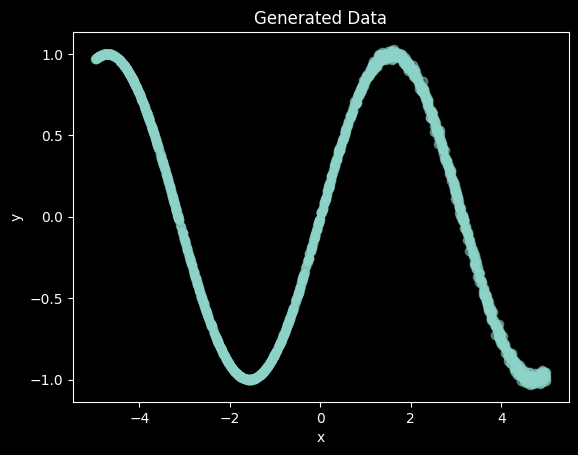

In [6]:
x_values, y_values = generate_data()

plt.scatter(x_values, y_values, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated Data')
plt.show()

Great, we've got our model. Now let's fit it with a standard Regression NN.

In [7]:
# Generate data
x_values, y_values = generate_data(num_points=10000)

# Convert data to PyTorch tensors
x_tensor = torch.tensor(x_values, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y_values, dtype=torch.float32).unsqueeze(1)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, test_size=0.1, random_state=42)

# Create a DataLoader for training data
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [8]:
# Define the neural network
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [9]:
# Function for training
def train_regression_nn(train_loader, model, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

# Function for evaluation
def evaluate_regression_nn(test_loader, model, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
    return running_loss / len(test_loader.dataset)

In [10]:
# Check for CUDA availability and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate and train the network
model = RegressionNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the network
num_epochs = 100
progress_bar = tqdm(range(num_epochs), desc="Training", unit="epoch")
for epoch in progress_bar:
    train_loss = train_regression_nn(train_loader, model, criterion, optimizer)
    val_loss = evaluate_regression_nn(val_loader, model, criterion)

    progress_bar.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})

Training: 100%|██████████| 100/100 [00:09<00:00, 10.52epoch/s, Train Loss=0.0005, Val Loss=0.0006]


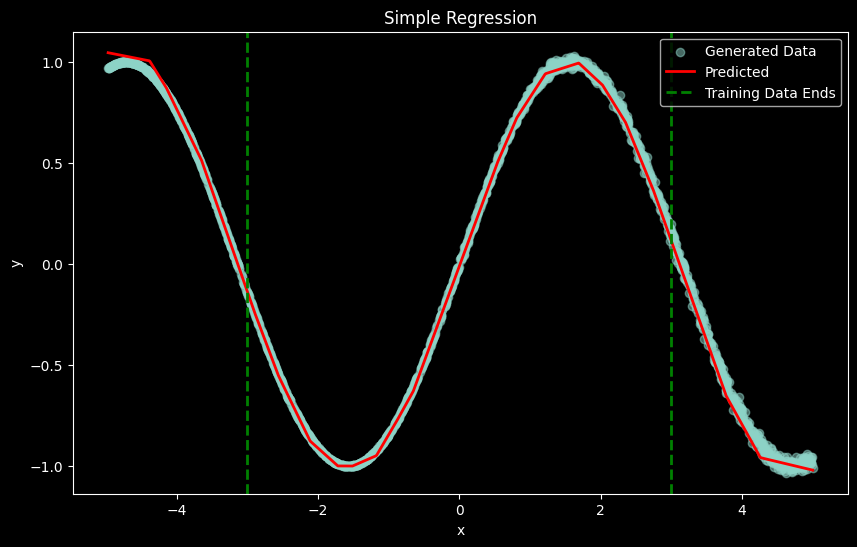

In [11]:
x_values, y_values = generate_data(x_min=-5, x_max=5)

x_for_prediction = np.sort(x_values)
x_for_prediction_tensor = torch.tensor(x_for_prediction, dtype=torch.float32).unsqueeze(1)

with torch.no_grad():
    y_predicted_tensor = model(x_for_prediction_tensor)
    y_predicted = y_predicted_tensor.squeeze().numpy()

plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, alpha=0.5, label="Generated Data")
plt.plot(x_for_prediction, y_predicted, label="Predicted", color='r', linestyle='-', linewidth=2)

plt.axvline(x=-3, color='g', linestyle='--', linewidth=2, label="Training Data Ends")
plt.axvline(x=3, color='g', linestyle='--', linewidth=2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Simple Regression')
plt.legend()
plt.show()


It fit the mean quite well. Now let's see about alleatoric uncertainty!

In [12]:
class GaussianDNN(nn.Module):
    def __init__(self):
        super(GaussianDNN, self).__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.mean_output = nn.Linear(32, 1)
        self.logvar_output = nn.Linear(32, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        mean = self.mean_output(x)
        logvar = self.logvar_output(x)
        return mean, logvar


In [13]:
def train_gaussian_dnn(train_loader, model, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        mean, logvar = model(inputs)
        
        loss = 0.5 * (torch.exp(-logvar) * (targets - mean)**2 + logvar).mean()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

def evaluate_gaussian_dnn(val_loader, model):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            mean, logvar = model(inputs)
            
            loss = 0.5 * (torch.exp(-logvar) * (targets - mean)**2 + logvar).mean()
            running_loss += loss.item() * inputs.size(0)
    return running_loss / len(val_loader.dataset)

In [14]:
# Instantiate and train the Gaussian DNN model
gaussian_dnn_model = GaussianDNN().to(device)
optimizer = optim.Adam(gaussian_dnn_model.parameters(), lr=0.01)

num_epochs = 200
progress_bar = tqdm(range(num_epochs), desc="Training Gaussian DNN", unit="epoch")
for epoch in progress_bar:
    train_loss = train_gaussian_dnn(train_loader, gaussian_dnn_model, optimizer)
    val_loss = evaluate_gaussian_dnn(val_loader, gaussian_dnn_model)
    
    progress_bar.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})

Training Gaussian DNN: 100%|██████████| 200/200 [00:24<00:00,  8.10epoch/s, Train Loss=-3.5207, Val Loss=-3.1453]


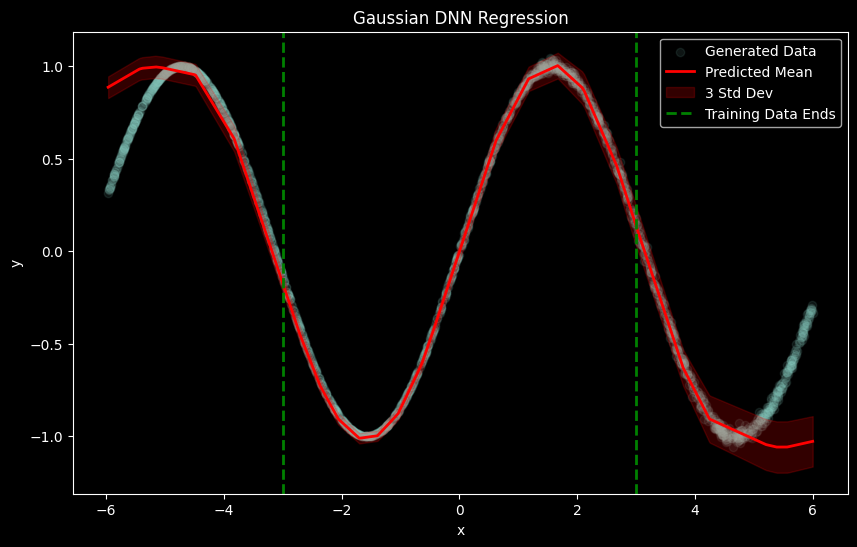

In [15]:
x_values, y_values = generate_data(x_min=-6, x_max=6)

x_for_prediction = np.sort(x_values)
x_for_prediction_tensor = torch.tensor(x_for_prediction, dtype=torch.float32).unsqueeze(1)

with torch.no_grad():
    mean_predicted_tensor, logvar_predicted_tensor = gaussian_dnn_model(x_for_prediction_tensor)
    mean_predicted = mean_predicted_tensor.squeeze().numpy()
    std_predicted = np.sqrt(np.exp(logvar_predicted_tensor.squeeze().numpy()))

plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, alpha=0.1, label="Generated Data")
plt.plot(x_for_prediction, mean_predicted, label="Predicted Mean", color='r', linestyle='-', linewidth=2)
plt.fill_between(x_for_prediction, mean_predicted - 3 * std_predicted, mean_predicted + 3 * std_predicted, color='r', alpha=0.2, label="3 Std Dev")

plt.axvline(x=-3, color='g', linestyle='--', linewidth=2, label="Training Data Ends")
plt.axvline(x=3, color='g', linestyle='--', linewidth=2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian DNN Regression')
plt.legend()
plt.show()


It did a great job within the training data bounds, but kinda flopped outside it. Now we'll implement epistemic uncertainty handling with MC Dropout.

In [ ]:
class GaussianDNNWithDropout(nn.Module):
    def __init__(self):
        super(GaussianDNNWithDropout, self).__init__()
        self.fc1 = nn.Linear(1, 32)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(32, 32)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(32, 32)
        self.dropout3 = nn.Dropout(p=0.2)
        self.mean_output = nn.Linear(32, 1)
        self.logvar_output = nn.Linear(32, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout1(x)
        x = self.activation(self.fc2(x))
        x = self.dropout2(x)
        x = self.activation(self.fc3(x))
        x = self.dropout3(x)
        mean = self.mean_output(x)
        logvar = self.logvar_output(x)
        return mean, logvar

    def predict(self, x, num_samples=50):
        self.train()
        mean_samples = []
        log_var_samples = []
        for _ in range(num_samples):
            mean, logvar = self.forward(x)
            mean_samples.append(mean)
            log_var_samples.append(logvar)

        mean_samples = torch.stack(mean_samples, dim=0)
        log_var_samples = torch.stack(log_var_samples, dim=0)
        var_samples = torch.exp(log_var_samples)

        mean_samples_squared = mean_samples ** 2
        mean = mean_samples.mean(dim=0)
        var = mean_samples_squared.mean(dim=0) - (mean ** 2) + var_samples.mean(dim=0)
        return mean, var


In [ ]:
def train_gaussian_with_dropout_dnn(train_loader, model, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        mean, var = model.predict(inputs)
        logvar = torch.log(var)
        
        loss = 0.5 * (torch.exp(-logvar) * (targets - mean)**2 + logvar).mean()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

def evaluate_gaussian_with_dropout_dnn(val_loader, model):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            mean, var = model.predict(inputs)
            logvar = torch.log(var)

            loss = 0.5 * (torch.exp(-logvar) * (targets - mean)**2 + logvar).mean()
            running_loss += loss.item() * inputs.size(0)
    return running_loss / len(val_loader.dataset)

In [ ]:
# Instantiate and train the Gaussian DNN model
gaussian_dnn_with_dropout_model = GaussianDNNWithDropout().to(device)
optimizer = optim.Adam(gaussian_dnn_with_dropout_model.parameters(), lr=0.01)

num_epochs = 100
progress_bar = tqdm(range(num_epochs), desc="Training Gaussian DNN", unit="epoch")
for epoch in progress_bar:
    train_loss = train_gaussian_with_dropout_dnn(train_loader, gaussian_dnn_with_dropout_model, optimizer)
    val_loss = evaluate_gaussian_with_dropout_dnn(val_loader, gaussian_dnn_with_dropout_model)
    
    progress_bar.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})

Training Gaussian DNN: 100%|██████████| 100/100 [15:03<00:00,  9.03s/epoch, Train Loss=-2.2670, Val Loss=-2.2266]


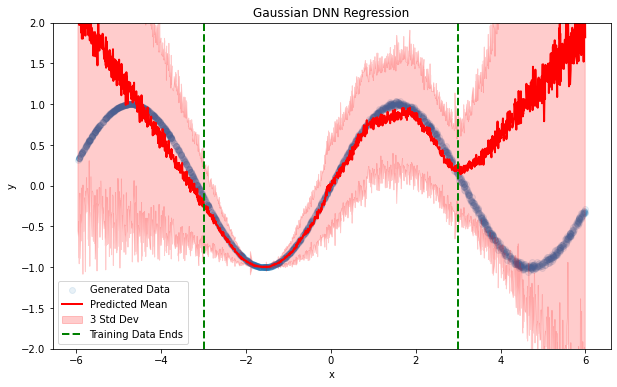

In [ ]:
x_values, y_values = generate_data(x_min=-6, x_max=6)

x_for_prediction = np.sort(x_values)
x_for_prediction_tensor = torch.tensor(x_for_prediction, dtype=torch.float32).unsqueeze(1)

with torch.no_grad():
    mean_predicted_tensor, variance_predicated_tensor = gaussian_dnn_with_dropout_model.predict(x_for_prediction_tensor, num_samples=50)
    mean_predicted = mean_predicted_tensor.squeeze().numpy()
    std_predicted = np.sqrt(variance_predicated_tensor.squeeze().numpy())

plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, alpha=0.1, label="Generated Data")
plt.plot(x_for_prediction, mean_predicted, label="Predicted Mean", color='r', linestyle='-', linewidth=2)
plt.fill_between(x_for_prediction, mean_predicted - 3 * std_predicted, mean_predicted + 3 * std_predicted, color='r', alpha=0.2, label="3 Std Dev")

plt.axvline(x=-3, color='g', linestyle='--', linewidth=2, label="Training Data Ends")
plt.axvline(x=3, color='g', linestyle='--', linewidth=2)

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2, 2)
plt.title('Gaussian DNN Regression')
plt.legend()
plt.show()


We can do a similiar thing by using Pyro and MCMC to create our weights

In [ ]:
!pip3 install pyro-ppl==1.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

In [ ]:
class PyroGaussianDNN(PyroModule):
    def __init__(self):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](1, 32)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([32, 1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([32]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](32, 32)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([32, 32]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([32]).to_event(1))
        self.mean = PyroModule[nn.Linear](32, 1)
        self.mean.weight = PyroSample(dist.Normal(0., 1.).expand([1, 32]).to_event(2))
        self.mean.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.mean(x).squeeze()
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return mu

In [ ]:
x, y = generate_data(num_points=10000)
x_train = torch.from_numpy(x).float()
y_train = torch.from_numpy(y).float()

model = PyroGaussianDNN().to(device)
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 1e-3})
svi = SVI(model, guide, adam, loss=Trace_ELBO())
pyro.clear_param_store()

x_train.to(device)
y_train.to(device)

num_epochs = 20000
progress_bar = tqdm(range(num_epochs), desc="Training Gaussian DNN", unit="epoch")
for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    
    progress_bar.set_postfix({"Train Loss": f"{loss / x_train.shape[0]:.4f}"})

Training Gaussian DNN:   0%|          | 0/20000 [00:00<?, ?epoch/s]

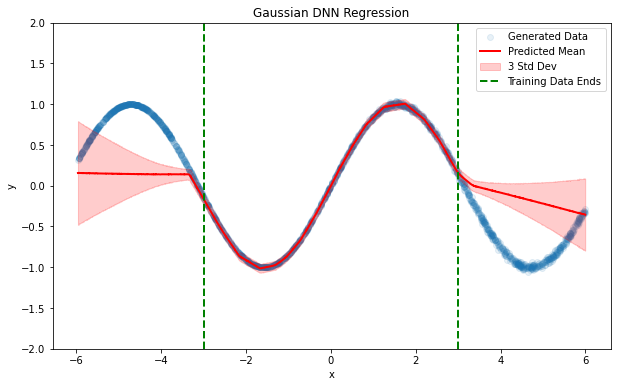

In [ ]:
predictive = Predictive(model, guide=guide, num_samples=500)

x_values, y_values = generate_data(x_min=-6, x_max=6)

x_for_prediction = np.sort(x_values)
x_for_prediction_tensor = torch.tensor(x_for_prediction, dtype=torch.float32).unsqueeze(1)

preds = predictive(x_for_prediction_tensor)
mean_predicted = preds['obs'].T.detach().numpy().mean(axis=1)
std_predicted = preds['obs'].T.detach().numpy().std(axis=1)

plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, alpha=0.1, label="Generated Data")
plt.plot(x_for_prediction, mean_predicted, label="Predicted Mean", color='r', linestyle='-', linewidth=2)
plt.fill_between(x_for_prediction, mean_predicted - 3 * std_predicted, mean_predicted + 3 * std_predicted, color='r', alpha=0.2, label="3 Std Dev")

plt.axvline(x=-3, color='g', linestyle='--', linewidth=2, label="Training Data Ends")
plt.axvline(x=3, color='g', linestyle='--', linewidth=2)

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2, 2)
plt.title('Gaussian DNN Regression')
plt.legend()
plt.show()

Now let's sample with MCMC instead of SVI

In [ ]:
from pyro.infer import MCMC, NUTS, Predictive

In [ ]:
x, y = generate_data(num_points=10000)
x_train = torch.from_numpy(x).float()
y_train = torch.from_numpy(y).float()

mcmc_model = PyroGaussianDNN().to(device)
x_train.to(device)
y_train.to(device)

nuts_kernel = NUTS(mcmc_model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100)
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 1100/1100 [2:38:35,  8.65s/it, step size=1.27e-04, acc. prob=0.937]


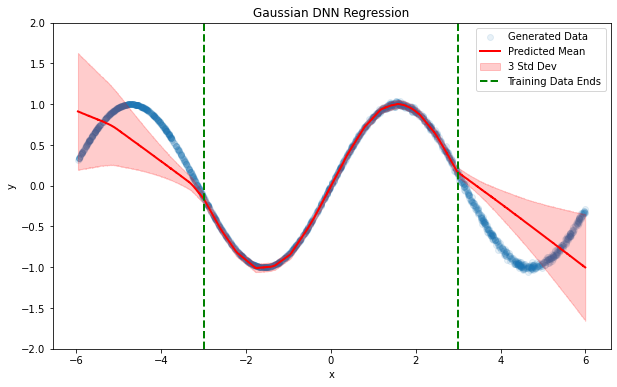

In [ ]:
mcmc_predictive = Predictive(mcmc_model, guide=guide, num_samples=500)

x_values, y_values = generate_data(x_min=-6, x_max=6)

x_for_prediction = np.sort(x_values)
x_for_prediction_tensor = torch.tensor(x_for_prediction, dtype=torch.float32).unsqueeze(1)

preds = mcmc_predictive(x_for_prediction_tensor)
mean_predicted = preds['obs'].T.detach().numpy().mean(axis=1)
std_predicted = preds['obs'].T.detach().numpy().std(axis=1)

plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, alpha=0.1, label="Generated Data")
plt.plot(x_for_prediction, mean_predicted, label="Predicted Mean", color='r', linestyle='-', linewidth=2)
plt.fill_between(x_for_prediction, mean_predicted - 3 * std_predicted, mean_predicted + 3 * std_predicted, color='r', alpha=0.2, label="3 Std Dev")

plt.axvline(x=-3, color='g', linestyle='--', linewidth=2, label="Training Data Ends")
plt.axvline(x=3, color='g', linestyle='--', linewidth=2)

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2, 2)
plt.title('Gaussian DNN Regression')
plt.legend()
plt.show()